# APS1070
#### Project 1 --- Basic Principles and Models 
**Deadline: Feb 2nd, 11PM - 10 percent**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Name: *(here and elsewhere, please replace the underscore with your answer)*

Student ID: 

##**Marking Scheme:**

This project is worth **10 percent** of your final grade.

Draw a plot or table where necessary to summarize your findings. 

**Practice Vectorized coding**: If you need to write a loop in your solution, think about how you can implement the same functionality with vectorized operations. Try to avoid loops as much as possible (in some cases, loops are inevitable).




### How to submit **(HTML + IPYNB)**

1. Download your notebook: `File -> Download .ipynb`

2. Click on the Files icon on the far left menu of Colab

3. Select & upload your `.ipynb` file you just downloaded, and then obtain its path (right click) (you might need to hit the Refresh button before your file shows up)


4. execute the following in a Colab cell:
```
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb
```

5. An HTML version of your notebook will appear in the files, so you can download it.

6. Submit **both** <font color='red'>`HTML` and `IPYNB`</font>  files on Quercus for grading.



Ref: https://stackoverflow.com/a/64487858 



# Project 1 [10 Marks] 
Let's apply the tools we have learned in the tutorial to a new dataset.

We're going to work with a [diabetes dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html). Download it using the cell below:

In [118]:
from sklearn.datasets import load_diabetes
import numpy as np
import matplotlib.pyplot as plt
dataset = load_diabetes()

## Part 1: Getting started [2.5 Marks]
First off, take a look at the `data`, `target` and `feature_names` entries in the `dataset` dictionary. They contain the information we'll be working with here. Then, create a Pandas DataFrame called `df` containing the data and the targets, with the feature names as column headings. If you need help, see [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for more details on how to achieve this. **[0.4]**
* How many features do we have in this dataset? 10
* Determine the median target value. 140.5
* How many participants have a target value greater than the median target value? 221

Now add an additional column containing either 0 (if the target value is below the median) or 1 (if the target value is above the median). This will be the new target value to classify the data as "diabetes severity below median" or "diabetes severity above median". **[0.5]**

### Splitting the data
It is best practice to have a training set (from which there is a rotating validation subset) and a test set. Our aim here is to (eventually) obtain the best accuracy we can on the test set (we'll do all our tuning on the training/validation sets, however.) 

**Split the dataset** into a train and a test set **"70:30"**, use **``random_state=0``**. The test set is set aside (untouched) for final evaluation, once hyperparameter optimization is complete. **[0.5]**

**Only Split the dataset once within you notebook.** You should not use the `train_test_split` function more than once, regardless of the random state. Keep this in mind for your future projects as well.

In [119]:
from sklearn.model_selection import train_test_split
import pandas as pd
df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target
median_target = np.median(dataset.target)
df['binary_target'] = df.target.map(lambda x: 0 if x <= median_target else 1)
df_train, df_test = train_test_split(df, train_size=0.7, random_state=0)


### Effect of Standardization (Visual)
Use `seaborn.lmplot` ([help here](https://seaborn.pydata.org/generated/seaborn.lmplot.html)) to visualize a few features of the training set. Draw a plot where the x-axis is ``age``, the y-axis is ``bmi,`` and the color of each datapoint indicates its class.  **[0.5]**

Standardizing the data is often critical in machine learning. Show a plot as above, but standardize the two features. What's different? **why do they look similar?** Based on your observation, what is the advantage of standardization? **[0.6]**




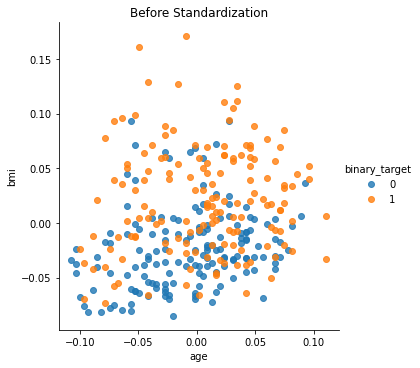

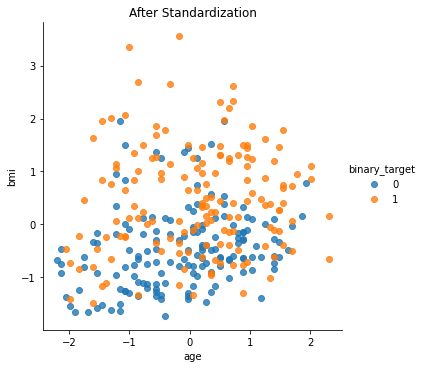

In [120]:
import seaborn as sb
sb.lmplot(data=df_train, x='age', y='bmi', hue='binary_target', fit_reg=False).set(title="Before Standardization")
plt.show()
standardized_df_train = (df_train - df_train.mean()) / df_train.std()
standardized_df_train['binary_target'] = df_train.binary_target
sb.lmplot(data=standardized_df_train, x='age', y='bmi', hue='binary_target', fit_reg=False).set(title="After Standardization")
plt.show()



> The standardized plot looks similar to the original because the original data's age and bmi standard deviations were already close and the difference in their means was negligeable. An advantage of standardization is that each feature contributes equally to the data, which is important especially for distance based models such as KNNs. The model is able to learn from a feature's relative value compared to the mean as opposed to its collected value, which is less important to an accurate model since it depends on factors such as scaling.

In [121]:
print(f"Std-deviation ratio: {df_train.std()['age'] / df_train.std()['bmi']}, mean-difference: {df_train.mean()['age'] - df_train.mean()['bmi']}")

Std-deviation ratio: 1.0001271542046093, mean-difference: 0.0006153205661193753


## Part 2: KNN Classifier without Standardization [2 Marks]
Normally, standardizing data is a key step in preparing data for a KNN classifier. However, for educational purposes, let's first try to build a model without standardization. Let's create a KNN classifier to predict whether a patient has a diabetes severity that is less than the median or greater than the median. 

Follow these steps: 

1.   Train a KNN Classifier using cross-validation on the dataset. Sweep `k` (number of neighbours) from 1 to 100, and show a plot of the mean cross-validation accuracy vs `k`. **[1]**
2.   What is the best `k`? What is the highest cross-validation accuracy? **[0.5]**
3. Comment on  which ranges of `k` lead to underfitted or overfitted models (hint: compare training and validation curves!). **[0.5]**




In [122]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

train_acc = []
val_acc = []
for k in range(1, 101):
  KNN = KNeighborsClassifier(n_neighbors=k)
  scores = cross_validate(KNN, df_train[dataset.feature_names], df_train.binary_target, cv=5, return_train_score=True)
  train_acc.append(scores['train_score'].mean())
  val_acc.append(scores['test_score'].mean())

max_acc = max(val_acc)
max_i = val_acc.index(max_acc)
print(f"Optimal K: {max_i}, Max Accuracy: {max_acc} ")



Optimal K: 14, Max Accuracy: 0.7542570068746695 


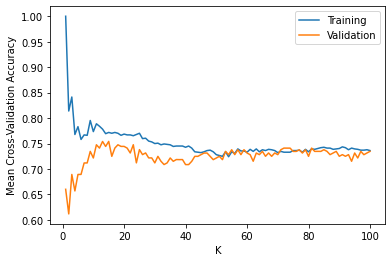

In [123]:
plt.plot(range(1, 101), train_acc, label="Training")
plt.plot(range(1, 101), val_acc, label="Validation")
plt.xlabel('K')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.legend()
plt.show()

> The optimal `k` was $14$ which achieved the highest cross validation accuracy of $ 0.754$. `k` ranging from $1$ to $13$ lead to model underfitting since the training accuracy was much higher than the validation accuracy in this range, but after `k`=$14$ both curves plateau. There was no significant overfitting since the training and validation accuracies did not increase and decrease significantly, respectively. 

## Part 3: Feature Selection [3 Marks]
In this part, we aim to investigate the importance of each feature on the final classification accuracy. 
If we want to try every possible combination of features, we would have to test  $2^F$ different cases,  where F is the number of features, and in each case, we have to do a hyperparameter search (finding K, in KNN using cross-validation). That will take days!. 

To find more important features we will use a decision tree. based on a decision tree we can compute feature importance that is a metric for our feature selection (code is provided below).

You can use [this link](https://machinelearningmastery.com/calculate-feature-importance-with-python/
) to get familiar with extracting the feature impotance order of machine learning algorithms in Python.

After we identified and removed the least important feature and evaluated a new KNN model on the new set of features, if the stop conditions (see step 7 below) are not met, we need to repeat the process and remove another feature.


Design a function ( `Feature_selector`) that accepts your dataset (X_train , y_train) and a threshold as inputs and: **[1]**
1. Fits a decision tree classifier on the training set.

2. Extracts the feature importance order of the decision tree model.

3. Removes the least important feature based on step 2. 
4. Then, a KNN model is trained on the remaining features. The number of neighbors (`k`) for each KNN model should be tuned using a 5-fold cross-validation.
5. Store the best `mean cross-validation` score and the corresponding `k` (number of neighbours) value in two lists.
6. Go back to step 3 and follow all the steps until you meet the stop condition (step 7). 
 
7. We will stop this process when (1) there is only one feature left, or (2) our cross-validation accuracy is dropped significantly compared to a model that uses all the features. In this function, we accept a threshold as an input argument. For example, if threshold=0.95 we do not continue removing features if our mean cross-validation accuracy after tuning `k` is bellow **0.95 $\times$ Full Feature cross-validation accuracy**.

8. Your function returns the list of removed features, and the corresponding mean cross-validation accuracy and `k` value when a feature was removed.

* Visualize your results by plotting the mean cross-validation accuracy (with a tuned `k` on y axis) vs. the on the number of features (x axis). This plot describes: what is the best cv score with 1 feature, 2 features, 3 features ... and all the features. **[0.5]**

* Plot the best value of `k` (y-axis) vs. the number of features. This plot explains the trend of number of neighbours with respect to the number of features.  **[0.5]**

* State what is the number of essential features for classification and justify your answer. **[1]**
  
  







 

You can use the following piece of code to start training a decision tree classifier and obtain its feature importance order. 
```
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)
importance = dt.feature_importances_
```


In [159]:
from sklearn import tree

def Feature_selector(X_train , y_train , tr=0.95):
  dt = tree.DecisionTreeClassifier()
  dt.fit(X_train, y_train)
  importance = dt.feature_importances_.tolist()
  # KNN with all features

  val_acc = []
  for k in range(1, 101):
    KNN = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(KNN, X_train[dataset.feature_names], y_train, cv=5, return_train_score=True)
    val_acc.append(scores['test_score'].mean())

  min_acc = max(val_acc)
  min_acc_k = val_acc.index(min_acc)

  removed_features = [None]
  feature_acc = [min_acc]
  feature_k = [min_acc_k]

  curr_acc = min_acc
  curr_features = dataset.feature_names.copy()
  curr_importances = importance.copy()
  # KNN with progressively fewer features
  while len(curr_features) > 1:

    min_importance = min(curr_importances)
    least_important_feature_i = importance.index(min_importance)
    least_important_feature = dataset.feature_names[least_important_feature_i]

    curr_features.remove(least_important_feature)
    curr_importances.remove(min_importance)

    curr_val_acc = []
    for k in range(1, 101):
      KNN = KNeighborsClassifier(n_neighbors=k)
      scores = cross_validate(KNN, df_train[curr_features], df_train.binary_target, cv=5, return_train_score=True)
      curr_val_acc.append(scores['test_score'].mean())

    curr_max_acc = max(curr_val_acc)
    curr_max_acc_k = curr_val_acc.index(curr_max_acc)

    if curr_max_acc >= tr * min_acc:
      removed_features.append(least_important_feature)
      feature_acc.append(curr_max_acc)
      feature_k.append(curr_max_acc_k)
    else:
      break

  return removed_features, feature_acc, feature_k

removed_features, feature_acc, feature_k = Feature_selector(df_train[dataset.feature_names], df_train.binary_target, 0.95)


In [160]:
removed_features, feature_acc, feature_k

([None, 'sex', 's4', 's1', 'age', 'bp', 's6', 's2', 's3', 'bmi'],
 [0.7542570068746695,
  0.7476996298254891,
  0.7539925965097833,
  0.7540983606557378,
  0.7670544685351667,
  0.7638286620835537,
  0.7637757800105763,
  0.779904812268641,
  0.7573241671073507,
  0.7248016922263353],
 [14, 23, 90, 98, 39, 30, 18, 14, 87, 84])

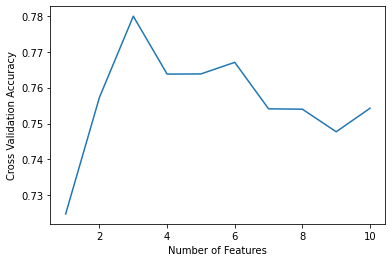

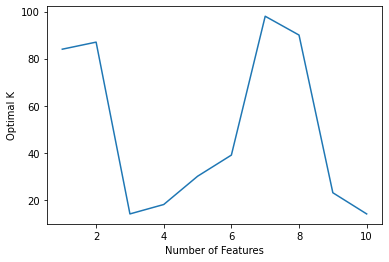

In [161]:
feature_acc_reverse = feature_acc.copy()
feature_acc_reverse.reverse()
plt.plot(range(10 - (len(removed_features) - 1), 11), feature_acc_reverse)
plt.xlabel('Number of Features')
plt.ylabel('Cross Validation Accuracy')
plt.show()

feature_k_reverse = feature_k.copy()
feature_k_reverse.reverse()
plt.plot(range(10 - (len(removed_features) - 1), 11), feature_k_reverse)
plt.xlabel('Number of Features')
plt.ylabel('Optimal K')
plt.show()

> There are $3$ essential features for classification, which is determined because $3$ features yields the highest cross validation accuracy ($\approx 0.78$) and the lowest `k` ($14$), meaning the relatively high accuracy was attainable with low complexity in the model as would be the case if only the most important features were factored in. 

## Part 4: Standardization [1 Marks]

Standardizing the data usually means scaling our data to have a mean of zero and a standard deviation of one. 

**Note:** When we standardize a dataset, do we care if the data points are in our training set or test set? Yes! The training set is available for us to train a model - we can use it however we want. The test set, however, represents a subset of data that is not available for us during training. For example, the test set can represent the data that someone who bought our model would use to see how the model performs (which they are not willing to share with us).
Therefore, we cannot compute the mean or standard deviation of the whole dataset to standardize it - we can only calculate the mean and standard deviation of the training set. However, when we sell a model to someone, we can say what our scalers (mean and standard deviation of our training set) was. They can scale their data (test set) with our training set's mean and standard deviation. Of course, there is no guarantee that the test set would have a mean of zero and a standard deviation of one, but it should work fine.

**To summarize: We fit the StandardScaler only on the training set. We transform both training and test sets with that scaler.**

1. Standardize the training  and test data ([Help](https://scikit-learn.org/stable/modules/preprocessing.html)) 

2. Call your ``Feature_selector`` function on the standardized training data with a threshold of 95\%. 
 * Plot the Cross validation accuracy when we have the standardized data (this part) and the original training data (last part) vs. the Number of features in a single plot (to compare them easily).

3. Discuss how standardization affected your model and its performance? 


In [167]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(df_train[dataset.feature_names])
scaled_df_train = pd.DataFrame(data=scaler.transform(df_train[dataset.feature_names]), columns=dataset.feature_names)
scaled_df_train['binary_target'] = df_train.binary_target
scaled_removed_features, scaled_feature_acc, scaled_feature_k = Feature_selector(scaled_df_train[dataset.feature_names], df_train.binary_target, 0.95)



In [170]:
scaled_removed_features, scaled_feature_acc, scaled_feature_k

([None, 'sex', 's4', 's6', 'bp', 's1', 'age', 's3', 'bmi', 's2'],
 [0.754151242728715,
  0.7476996298254891,
  0.7539925965097833,
  0.7575356953992596,
  0.7445267054468534,
  0.7540454785827604,
  0.7637757800105763,
  0.7540983606557378,
  0.7248545742993127,
  0.7248016922263353],
 [12, 23, 90, 6, 29, 6, 18, 59, 81, 84])

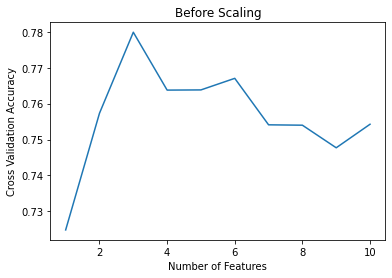

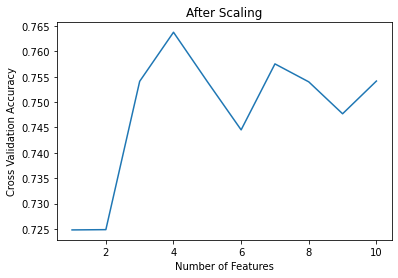

In [169]:
plt.plot(range(10 - (len(removed_features) - 1), 11), feature_acc_reverse)
plt.title("Before Scaling")
plt.xlabel('Number of Features')
plt.ylabel('Cross Validation Accuracy')
plt.show()

scaled_feature_acc_reverse = scaled_feature_acc.copy()
scaled_feature_acc_reverse.reverse()
plt.plot(range(10 - (len(scaled_removed_features) - 1), 11), scaled_feature_acc_reverse)
plt.xlabel('Number of Features')
plt.ylabel('Cross Validation Accuracy')
plt.title("After Scaling")
plt.show()



In [172]:
df_train[dataset.feature_names].mean(), df_train[dataset.feature_names].std()

(age   -0.000683
 sex    0.001014
 bmi   -0.001298
 bp    -0.000111
 s1    -0.000193
 s2    -0.000469
 s3     0.000511
 s4     0.000304
 s5    -0.000845
 s6    -0.000783
 dtype: float64, age    0.048374
 sex    0.047696
 bmi    0.048368
 bp     0.047747
 s1     0.047455
 s2     0.047667
 s3     0.048294
 s4     0.048989
 s5     0.049173
 s6     0.051119
 dtype: float64)

> Standardization made one more feature important, since after scaling the feature count yielding optimal cross validation accuracy went from $3$ to $4$. One can also observe that the shape of the plot after standardization does not significantly change, explained by the fact that the features follow a similar distribution, with mean $\approx 0$ and standard deviation $\approx 0.05$. Thus, for similarly distributed features, standardization yields little benefit to a model. 

## Part 5: Decision Tree Classifier [1 Mark]

Train a decision tree classifier on the standardized dataset (read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and check the example there.) Tune the `max_depth` and `min_samples_split` parameters of the tree using cross-validation (CV).
 * Compare the decision tree's performance (mean CV score) with KNN, both using all the features. 


In [210]:

from sklearn.model_selection import GridSearchCV

dt = tree.DecisionTreeClassifier()

params = {'max_depth': [i for i in range(1, 101)], 'min_samples_split': [i for i in range(2, 101)]}
clf = GridSearchCV(estimator=dt, param_grid=params, cv=5, n_jobs=-1)
clf.fit(scaled_df_train[dataset.feature_names], df_train.binary_target)



GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 29, 30, 31, ...]})

In [211]:
clf_params, clf_results = clf.cv_results_['params'], clf.cv_results_['mean_test_score'].tolist()
max_acc = max(clf_results)
max_params = clf_params[clf_results.index(max_acc)]
print(f"Optimal Params: {max_params} | Max Accuracy:  {max_acc}")

Optimal Params: {'max_depth': 5, 'min_samples_split': 71} | Max Accuracy:  0.7474352194606029


The decision tree's mean score was $0.75$, achieved with a `max_depth` of $5$ and a `min_samples_split` of 71, after exhausting a search through values between $1$($2$) to $100$ over both parameters, respectively. This is slighly worse than the best KNN model thus far; the non-standardized KNN with $3$ selected features `['bmi', 's3', 's5']`, which achieved an accuracy of $0.78$ with `k`=$14$. 

## Part 6: Test Data [0.5 Mark]

Now that you've created several models, pick your best one (highest CV accuracy) and apply it to the test dataset you had initially set aside. Discuss your results.

In [220]:
KNN = KNeighborsClassifier(n_neighbors=14)
KNN.fit(df_train[['bmi', 's3', 's5']], df_train['binary_target'])
prediction = KNN.predict(df_test[['bmi', 's3', 's5']])
acc = (prediction == df_test['binary_target']).sum() / len(df_test)
print(f"Test Accuracy of KNN with K=14, trained on features ['bmi', 's3', 's5']: {acc}")

Test Accuracy of KNN with K=14, trained on features ['bmi', 's3', 's5']: 0.7443609022556391


The KNN model with `k`=14, trained on features `['bmi', 's3', 's5']` achieved a test accuracy of $0.744$ which is slighly lower than the $0.78$ achieved during the validation phase, but this is expected since the hyperparameters (in particular, `k`) was tuned to the validation sets and the test set is new to the model. 

References:

https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052

https://www.analyticsvidhya.com/blog/2021/02/machine-learning-101-decision-tree-algorithm-for-classification/